In [3]:
import random
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [146]:
orders = pd.read_csv('../source/orders_raw.csv')
print('length: ' + str(len(orders)))
orders.head(2)


length: 1000


,order_id,customer_id,order_date,order_type,order_status,shipping_amount,product_id,price,quantity
0,12069-4TMV42,12069,2017/08/23,Online,Shipped,17.54,230,72.75,1
1,11239-0LHH93,11239,2020/06/14,Retail,Completed,15.85,240,26.50,1


Add marketing tracking code to randomized orders

In [82]:
campaigns = pd.read_csv('../source/campaigns.csv')
campaigns['start_dt'] = pd.to_datetime(campaigns['start_date'])
campaigns['end_dt'] = pd.to_datetime(campaigns['end_date'])
campaigns.head()

,campaign_id,start_date,end_date,campaign,country,start_dt,end_dt
0,10001,2015-01-02,2015-01-06,2015 Transcof 7AR009,US,2015-01-02,2015-01-06
1,10002,2015-01-16,2015-01-26,2015 Domainer 9YO534,US,2015-01-16,2015-01-26
2,10003,2015-02-11,2015-02-23,2015 Ronstring 4QT243,US,2015-02-11,2015-02-23
3,10004,2015-03-05,2015-03-17,2015 Fintone 2PG648,US,2015-03-05,2015-03-17
4,10005,2015-03-26,2015-04-03,2015 Solarbreeze 9XQ101,US,2015-03-26,2015-04-03


In [83]:
channels = pd.read_csv('../source/campaign_channels.csv')
channels.head()

,campaign_id,channel_id,category,channel,budget,spend,tracking_code,campaign_channel_id
0,10001,605,In-Store,Signage,3200,4000,4NQSPX,10001IN4NQSPX
1,10001,904,Social,Forum,3900,3588,6FWEOU,10001SO6FWEOU
2,10002,723,Web,Microsites,2000,2400,7WHGTM,10002WE7WHGTM
3,10003,303,Direct,Postal Mail,4800,4896,9JUSKL,10003DI9JUSKL
4,10003,905,Social,Influencer outreach,2100,1995,3XNYND,10003SO3XNYND


In [138]:
def find_tracking_code(order_date):
    # campaigns that are effective around our order_date
    potential_campaigns = campaigns[(order_date >= campaigns['start_dt']) \
                                & (order_date <= campaigns['end_dt'])]
    pcl = len(potential_campaigns) # potential_campaigns length (could be zero)
    
    # select one of found campaigns at random, or none
    # This part is a little tricky
    #   if pcl is 0, then rn will be 0 and we return blank
    #   if pcl is 2, and rn is 2 then we return blank
    #     otherwise rn is an index into potential_campaigns
    rn = random.randint(0,pcl) # 
    if rn < pcl :
        cid = potential_campaigns.iloc[rn]['campaign_id'] # Chosen Campaign ID
    else:
        return ''
    # Find a channel
    pch = channels[channels['campaign_id'] == cid] # potential channels
    pchl = len(pch) # pot channels len
    sch = pd.Series() # selected channel
    if pchl == 0:
        return ''
    # retrive the selected channel
    return pch.iloc[random.randint(0,pchl-1)]['tracking_code']


Consolidates (discards) random orders so that each remaining order has one or more order lines. Creates the `order_line_id` key. 

In [185]:
new_orders = orders.copy()
new_orders.insert(loc=6, column='order_line_id', value=orders['order_id']+"-1")
new_orders.insert(loc=5, column='tracking_code', value="")


n = len(orders)
line = 1
for i, row in orders.iterrows():
    if (i + 1) == n: 
        break
        
    # Add a tracking code if one is selected
    tc = find_tracking_code(row['order_date'])

    # decide whether to consolidate the next row
    r = random.randint(0,1)
    
    if  r == 0: # no, reset the order-line #
        line = 1
        
    if line == 1:
        locked_row = row.copy()
        locked_tc = tc
    
    if r == 1: # yes, overwrite the next row
        if line == 1:
            new_orders.loc[i, 'tracking_code'] = locked_tc  
        line = line + 1
        new_orders.iloc[i+1,0:7] = locked_row[0:7]
        new_orders.loc[i+1, 'order_line_id'] = locked_row['order_id']+"-"+str(line)
        new_orders.loc[i+1, 'tracking_code'] = locked_tc
    

In [186]:
new_orders.head(n=10)

,order_id,customer_id,order_date,order_type,order_status,tracking_code,shipping_amount,order_line_id,product_id,price,quantity
0,12069-4TMV42,12069,2017/08/23,Online,Shipped,,17.54,12069-4TMV42-1,230,72.75,1
1,11239-0LHH93,11239,2020/06/14,Retail,Completed,0QVSXR,15.85,11239-0LHH93-1,240,26.50,1
2,11239-0LHH93,11239,2020/06/14,Retail,Completed,0QVSXR,15.85,11239-0LHH93-2,130,29.76,1
3,12172-1FWV29,12172,2020/10/05,Retail,Completed,3PZQDM,11.46,12172-1FWV29-1,310,32.34,1
4,12172-1FWV29,12172,2020/10/05,Retail,Completed,3PZQDM,11.46,12172-1FWV29-2,150,20.14,1
5,12287-0QYI21,12287,2020/12/04,Online,Shipped,,10.43,12287-0QYI21-1,310,32.34,1
6,11605-3INI74,11605,2017/05/15,Online,Shipped,,7.42,11605-3INI74-1,320,65.34,1
7,12734-5RPF16,12734,2019/10/15,Online,Shipped,5FAEIU,8.32,12734-5RPF16-1,410,276.00,1
8,12734-5RPF16,12734,2019/10/15,Online,Shipped,5FAEIU,8.32,12734-5RPF16-2,140,22.77,1
9,11712-8EIT44,11712,2018/10/07,Online,Shipped,,13.73,11712-8EIT44-1,120,33.12,1


In [192]:
new_orders.groupby('order_type')['customer_id'].count()

order_type
Online    766
Retail    234
Name: customer_id, dtype: int64

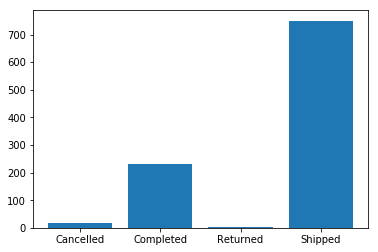

In [193]:
plt.clf()
plt.bar(np.sort(new_orders['order_status'].unique()),new_orders.groupby('order_status')['order_id'].count())
plt.show()

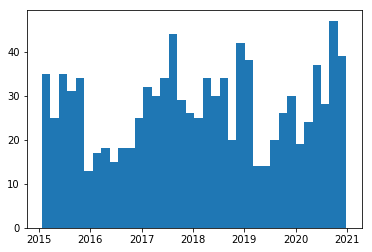

In [194]:
df = pd.DataFrame(pd.to_datetime(new_orders['order_date']))
plt.hist(df['order_date'], 36)
plt.show()

In [167]:
newfilename='../source/orders.csv_1_' + str(int(datetime.datetime.now().timestamp()))
new_orders.to_csv(newfilename, encoding='utf-8', index=False)